In [4]:
import numpy as np
import pandas as pd

import importlib
import os
import sys

from pathlib import Path

# Change these accordingly with the working directory
# sys.path.append("rt-evaluation/forecast_tools")
sys.path.append("../../forecast_tools")

import forecasting
import generation_time
import rt_projection
from rt_projection import RtData


# Read R(t) estimate data to use in forecasts

In [7]:
# ========== Parameters

# --- Labels of data fields
date_label = "reference_date"
count_label = "count"
snapshot_date_label = "snapshot_date"
rt_method_label = "rt_method"
report_date_label = "report_date"
trajectory_prefix = "traj"

# Columns to drop from input data
rt_exclude_cols = ["median", "lower_95", "upper_95"]

# --- Rt synthesis parameters
ndays_forecast = 14
ndays_past_rt_mean = 21  # How many days before "today" to average the R(t) estimates
rt_project_method = "linear"

# --- Generation time
tg_gamma_shape = 2.
tg_gamma_scale = 2.
tg_max = 20

# --- Postprocessing
use_quantiles = np.round(np.append(np.append([0.01, 0.025], np.arange(0.05, 0.95 + 0.05, 0.050)), [0.975, 0.99]), 6)
num_quantiles = use_quantiles.shape[0]

In [9]:
# --- Choose a target data file
data_fname = Path("../Test data/MA/MA_NoNoise.csv")
# data_fname = Path("../Test data/MA/MA_DelayNoise.csv")

# --- Choose an R(t) estimate file
rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiLPS.csv")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiEstim.csv")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiFilter.csv")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiNow.csv")

# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_E")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiEstim_noise_reporting_delay.csv")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiFilter_noise_reporting_delay.csv")
# rt_fname = Path("../rt_estimates/MA_1000_trajectory_Rt_estimates_EpiNow.csv")


data_df = pd.read_csv(data_fname, parse_dates=["report_date", "reference_date"])
rt_estim_df = pd.read_csv(rt_fname)

# --- Clean the target data df
data_df = data_df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, errors="ignore")
data_df = data_df.rename({"location": "county"}, axis=1)


# --- Clean the R(t) estimate data frame
rt_estim_df.drop(rt_exclude_cols, axis=1, errors="ignore", inplace=True)
rt_estim_df.rename({"date": "reference_date"}, axis=1, inplace=True)

# # # # # # # #MANUALLY FIX PAIRING ISSUES (TEMPORARY) # # # # # # #
rt_estim_df["county"] = 0
rt_estim_df["state"]  = 25

data_df["county"] = 0
data_df["state"]  = 25
data_df["label"]  = rt_estim_df["label"].unique()[0]

data_df = data_df.drop(["STATEFP"], axis=1)

# data_df
rt_estim_df

,reference_date,county,state,label,rt_method,snapshot_date,traj_0,traj_1,traj_2,traj_3,...,traj_990,traj_991,traj_992,traj_993,traj_994,traj_995,traj_996,traj_997,traj_998,traj_999
0,2025-10-01,0,25,leam_no_noise,EpiLPS,2026-03-29,3.565214,2.712021,4.230152,1.927497,...,4.049703,4.273078,5.190970,4.112469,2.653923,4.216114,4.003475,3.798910,4.071402,4.263641
1,2025-10-02,0,25,leam_no_noise,EpiLPS,2026-03-29,7.118365,7.096865,7.026266,7.191974,...,7.509440,7.052702,7.334377,7.022927,7.335773,7.026620,7.277052,7.205517,6.998214,7.208214
2,2025-10-03,0,25,leam_no_noise,EpiLPS,2026-03-29,3.309989,3.216980,3.418511,3.517508,...,3.553277,3.193790,3.415240,3.365023,3.306843,3.294644,3.503581,3.177321,3.267312,3.186658
3,2025-10-04,0,25,leam_no_noise,EpiLPS,2026-03-29,2.188862,2.362051,2.277339,2.189203,...,2.387360,2.150786,2.075738,2.198092,2.177020,2.323818,2.348054,2.468848,2.245769,2.296272
4,2025-10-05,0,25,leam_no_noise,EpiLPS,2026-03-29,1.870056,1.794848,1.706073,2.027924,...,1.804284,1.881342,1.653087,1.942260,1.682919,1.719577,1.906932,1.719116,1.907800,1.851853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2026-03-25,0,25,leam_no_noise,EpiLPS,2026-03-29,0.734644,0.724746,0.688462,0.722447,...,0.617436,0.714782,0.712738,0.685387,0.685225,0.801334,0.735933,0.711321,0.765450,0.655147
176,2026-03-26,0,25,leam_no_noise,EpiLPS,2026-03-29,0.713707,0.659980,0.675369,0.790334,...,0.800507,0.708235,0.830211,0.768114,0.782942,0.731171,0.743862,0.761764,0.691057,0.637028
177,2026-03-27,0,25,leam_no_noise,EpiLPS,2026-03-29,0.767038,0.721755,0.815122,0.751034,...,0.733781,0.765353,0.749084,0.687487,0.759648,0.603833,0.694751,0.675993,0.877494,0.705769
178,2026-03-28,0,25,leam_no_noise,EpiLPS,2026-03-29,0.740712,0.642001,0.725232,0.788978,...,0.667107,0.758384,0.788718,0.655629,0.721713,0.819905,0.649730,0.839331,0.630741,0.617172


# Prepare the data for the forecast

In [11]:
## Let's group and _align_ data of R(t) and truth

# ---- Agnostically determine the columns to groupby and the data columns
data_groupby_labels = [c for c in data_df.columns if c not in [date_label, count_label, snapshot_date_label, report_date_label]]

rt_trajectory_cols = [c for c in rt_estim_df.columns if c.startswith(trajectory_prefix)]
rt_grouby_labels    = [c for c in rt_estim_df.columns if c not in [date_label, count_label, snapshot_date_label] + rt_trajectory_cols] 


# CONSTRUCTION OF THE GENERATION TIME object
# =======================
tg_obj = generation_time.ConstGammaTg(shape=tg_gamma_shape, rate=1. / tg_gamma_scale, tmax=tg_max)

tg_obj.get_pmf_array()

array([0.        , 0.15491641, 0.1879231 , 0.17097168, 0.13826609,
       0.10482828, 0.07629788, 0.05398984, 0.03742456, 0.02553654,
       0.01720966, 0.011482  , 0.0075973 , 0.00499199, 0.0032607 ,
       0.00211898, 0.00137091, 0.00088347, 0.00056737, 0.00036325])

# Run the forecast

In [12]:
# ------- To make it work during the collabathon, we simply select one snapshot date and one rt method at a time. In the future, multiple combination can be run in a loop.
# -()- Take date from R(t) data (last point()
snapshot_date = rt_estim_df[snapshot_date_label].unique()[0]
# -()- Define by hand
# snapshot_date = pd.Timestamp("2025-12-31")  # PEAK (not working so far)

# Label of the R(t) estimation method
rt_method     = rt_estim_df[rt_method_label].unique()[0]


results = list()
for group in data_df.groupby(data_groupby_labels):
    # Extract variables
    vars_dict = dict(zip(data_groupby_labels, group[0]))
    gp_data_df = group[1]
    
    # --- Produce data snapshot (aggregate entries reported until snapshot_date)
    past_incidence_sr = (gp_data_df
        .loc[gp_data_df[report_date_label] <= snapshot_date]
        .drop(data_groupby_labels + [report_date_label], axis=1)
        .set_index(date_label)
        [count_label]
    )
    # display(truth_sr)
    
    # --- Pair with a subset of the R(t) estimates
    rt_estim_keys = list(vars_dict.keys()) + [rt_method_label, snapshot_date_label]
    rt_estim_vals = list(vars_dict.values()) + [rt_method, snapshot_date]
    xs_df = (rt_estim_df
          .set_index(rt_estim_keys)
          .xs(tuple(rt_estim_vals), level=tuple(rt_estim_keys))
          # [rt_trajectory_cols]
          .set_index(date_label)  # Also discards the previous index
    )
    # Ensure that no future R(t) enters the forecast
    xs_df = xs_df.loc[xs_df.index <= snapshot_date]
    
    # Create the past R(t) data structure
    rt_past =  RtData(xs_df.T.to_numpy())
    rt_past.df.columns = xs_df.index
    
    # -------------------
    
    # --- Forecast (project) R(t)
    rt_fore = RtData(
        rt_projection.static_ramp_avg_synth(
            ndays_forecast, rt_past, ndays_past_rt_mean, k_start=1, k_end=1,
        )
    )
    
    # --- Forecast I(t)
    
    fore_incidence = forecasting.reconstruct_ct(
        past_incidence_sr, rt_fore.df, tg_obj.get_pmf_array(), tg_obj.tmax, seed=456
    )
    
    results.append(fore_incidence)
    
    
display(results[0])

array([[59, 61, 64, ..., 19, 19, 13],
       [76, 60, 51, ..., 27, 19, 18],
       [69, 66, 54, ..., 15, 28, 26],
       ...,
       [87, 89, 85, ..., 59, 51, 48],
       [96, 76, 76, ..., 53, 48, 32],
       [97, 67, 78, ..., 63, 69, 61]])

In [13]:
# Forecast postprocessing
# ===================

snapshot_date = snapshot_date
ct_fore = results[0]  # Let's just select the first
#  ^ ^ signature: a[i_trajectory, i_day_fore]

# Let's add some meaning to the 
ct_q_2darray = np.quantile(ct_fore, q=use_quantiles, axis=0)
#   ^ ^ Signature: a[i_quantile, i_day_fore]

ct_q_df = pd.DataFrame(
    ct_q_2darray,
    index=use_quantiles,
    columns=pd.date_range(start=pd.Timestamp(snapshot_date) + pd.Timedelta("1d"), periods=ndays_forecast, freq="1d")
)
ct_q_df.index.name = "quantile"
ct_q_df.columns.name = "target_end_date"

# PREPARE HUBVERSE(ish) DATAFRAME
# ===============================
hubverse_ct_q_df = (
    ct_q_df
    .stack()
    .reset_index(drop=False)
    .rename({0: "value"}, axis=1)
)

# ---
display(hubverse_ct_q_df)

do_export = False  # SET THIS TO TRUE TO WRITE THE OUTPUTS INTO FILES 
out_fname = Path("../forecasts/forecast_epilps_nonoise.csv")
# out_fname = Path("../forecasts/forecast_epiestim_nonoise.csv")
# out_fname = Path("../forecasts/forecast_epifilter_nonoise.csv")
# out_fname = Path("../forecasts/forecast_epinow_nonoise.csv")

# out_fname = Path("../forecasts/forecast_epilps_noise-reporting.csv")
# out_fname = Path("../forecasts/forecast_epiestim_noise-reporting.csv")
# out_fname = Path("../forecasts/forecast_epifilter_noise-reporting.csv")
# out_fname = Path("../forecasts/forecast_epinow_noise-reporting.csv")
if do_export:
    hubverse_ct_q_df.to_csv(out_fname, index=False)
else:
    print(f"skipped. File name = {out_fname}")


,quantile,target_end_date,value
0,0.01,2026-03-30,57.99
1,0.01,2026-03-31,50.99
2,0.01,2026-04-01,46.00
3,0.01,2026-04-02,43.00
4,0.01,2026-04-03,38.00
...,...,...,...
317,0.99,2026-04-08,64.01
318,0.99,2026-04-09,61.00
319,0.99,2026-04-10,60.00
320,0.99,2026-04-11,55.00


skipped. File name = ../forecasts/forecast_epilps_nonoise.csv


# Plot the results for a quick check 
(Requires `matplotlib`)

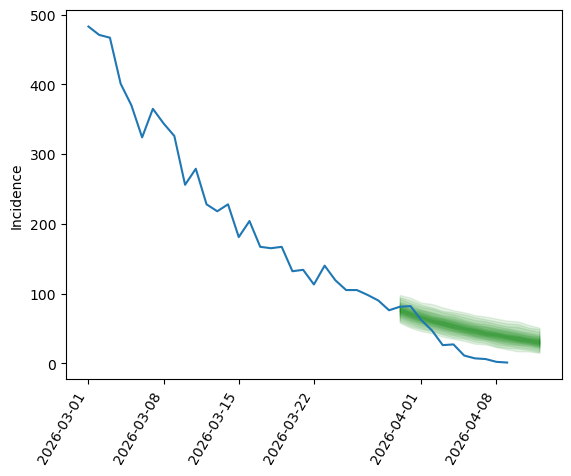

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl


def plot_fore_quantiles_as_area(
        ax, q_df: pd.DataFrame, prepend_point=None,
        color="green", alpha=0.10,
):
    """TODO
    expected signature: q_df.loc[iqr_idx, date]
    prepend_point: None or (date, val)
    """

    if prepend_point is not None:
        pre_date, pre_val = prepend_point
        # q_df = pd.concat([pd.DataFrame({pre_date: }), q_df])
        q_df.insert(0, pre_date, pre_val)

    x_array = q_df.columns
    num_layers = q_df.shape[0] // 2
    layers = list()

    for i_q in range(num_layers):
        layers.append(ax.fill_between(
            x_array, q_df.iloc[i_q], q_df.iloc[-(i_q + 1)],
                      alpha=alpha, color=color))

    return layers


# -----
for group in data_df.groupby(data_groupby_labels):
    # Extract variables
    vars_dict = dict(zip(data_groupby_labels, group[0]))
    gp_data_df = group[1]
    
    ground_truth_sr = (gp_data_df
            # .loc[gp_data_df[report_date_label] <= snapshot_date]  # Does not filter for reporting date
            .drop(data_groupby_labels + [report_date_label], axis=1)
            .set_index(date_label)
            [count_label]
        )
    
    break  # JUST TAKE THE FIRST POINT
    
def rotate_ax_labels(ax, angle=60, xy="x", which="major"):
    """This function could be included in my plot_tools."""
    labels = ax.get_xticklabels(which=which) \
        if xy == "x" else ax.get_yticklabels(which=which)
    for label in labels:
        label.set(rotation=angle, horizontalalignment='right')

# ------

fig, ax = plt.subplots()

plot_fore_quantiles_as_area(ax, ct_q_df)
# ax.plot(ct_q_df.loc[0.5], color="green", ls="--")
ax.plot(ground_truth_sr.loc[pd.Timestamp(snapshot_date) - pd.Timedelta("4w"):pd.Timestamp(snapshot_date) + pd.Timedelta("2w")])

# ax.set_xlim(ct_q_df.columns[0] - pd.Timedelta("2w"), ct_q_df.columns[0] + pd.Timedelta("2w"), )
# ax.set_ylim(0, 200)
ax.set_ylabel("Incidence")
rotate_ax_labels(ax)